In [1]:
from tensorflow.keras.utils    import to_categorical
from tensorflow.keras.datasets import mnist

from sklearn.datasets        import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder, StandardScaler


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
os.environ['PATH'] = '/xilinx/Vivado/2020.1/bin:' + os.environ['PATH']

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 420

tf.random.set_seed(seed)
np.random.seed    (seed)


In [2]:
USER_PATH    = os.getcwd()
DATA_PATH    = USER_PATH + "/Data/"
MODEL_PATH   = USER_PATH + "/Models/"
PROJECT_PATH = USER_PATH + "/HLS_projects/"
PLOTS_PATH   = USER_PATH + "/Plots/"


## Download data

In [3]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_test = to_categorical(y_test,10)

np.save(DATA_PATH + "y_test.npy", y_test)

In [4]:
from tensorflow.keras.models       import Sequential
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers       import Activation, BatchNormalization, Flatten, MaxPool2D, Reshape
from tensorflow.keras.layers       import Dense, Conv2D

from utils.callbacks import all_callbacks

from qkeras.qlayers    import QDense, QActivation
from qkeras            import QConv2D, QConv1D
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_tanh, binary_tanh

In [5]:
from tensorflow.keras.datasets import mnist
from qkeras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical

### Define Model

In [6]:
from tensorflow.keras.models import model_from_json
from qkeras.utils import _add_supported_quantized_objects; co = {}; _add_supported_quantized_objects(co)

def get_cnn_qmodel():
    x = x_in = Input((28,28,1), name="layer0")
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(4,1,0,alpha=1),
        bias_quantizer=quantized_bits(7,0,0,alpha=1),
        name="q_conv2d")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu")(x)
    x = MaxPooling2D((2,2), name='maxp')(x)
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(5,0,0,alpha=1),
        bias_quantizer=quantized_bits(6,0,0,alpha=1),
        name="q_conv2d_1")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_1")(x)
    x = MaxPooling2D((2,2), name='maxp_1')(x)
    #x = Conv2D(36, (3,3),
    #          name='Conv2')(x)
    #x = MaxPool2D((2,2), name='Max2')(x)
    x = Flatten()(x)
    x = QDense(10, name='q_dense',
              kernel_quantizer=quantized_bits(5,0,0,alpha=1),
              #kernel_quantizer="stochastic_ternary()",
              bias_quantizer=quantized_bits(6,0,0,alpha=1))(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model

def get_bigcnn_qmodel():
    x = x_in = Input((28,28,1), name="layer0")
    x = QConv2D(
        64, (3, 3),
        kernel_quantizer=quantized_bits(4,1,0,alpha=1),
        bias_quantizer=quantized_bits(7,0,0,alpha=1),
        name="q_conv2d")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu")(x)
    x = MaxPooling2D((2,2), name='maxp')(x)
    x = QConv2D(
        64, (3, 3),
        kernel_quantizer=quantized_bits(5,0,0,alpha=1),
        bias_quantizer=quantized_bits(6,0,0,alpha=1),
        name="q_conv2d_1")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_1")(x)
    x = MaxPooling2D((2,2), name='maxp_1')(x)
    x = QConv2D(
        32, (3, 3),
        kernel_quantizer=quantized_bits(5,0,0,alpha=1),
        bias_quantizer=quantized_bits(6,0,0,alpha=1),
        name="q_conv2d_2")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_2")(x)
    x = MaxPooling2D((2,2), name='maxp_2')(x)
    #x = Conv2D(36, (3,3),
    #          name='Conv2')(x)
    #x = MaxPool2D((2,2), name='Max2')(x)
    x = Flatten()(x)
    x = QDense(10, name='q_dense',
              kernel_quantizer=quantized_bits(5,0,0,alpha=1),
              #kernel_quantizer="stochastic_ternary()",
              bias_quantizer=quantized_bits(6,0,0,alpha=1))(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model


def get_dense_qmodel():
    x = x_in = Input((784,), name="layer0")
    x = QActivation("quantized_relu(2)", name="q_relu")(x)
    x = QDense(
        20,
        kernel_quantizer = quantized_bits(4,0, alpha=1),
        bias_quantizer   = quantized_bits(5,0, alpha=1),
        name="q_dense")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_1")(x)
    x = QDense(
        10,
        kernel_quantizer = quantized_bits(4,1, alpha=1),
        bias_quantizer   = quantized_bits(4,1, alpha=1),
        name='q_dense_1')(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model

def get_bigdense_qmodel():
    x = x_in = Input((784,), name="layer0")
    x = QActivation("quantized_relu(2)", name="q_relu")(x)
    x = QDense(
        140,
        kernel_quantizer = quantized_bits(7,0, alpha=1),
        bias_quantizer   = quantized_bits(7,0, alpha=1),
        name="q_dense")(x)
    x = QActivation("quantized_relu(2)", name="q_relu_1")(x)
    x = QDense(
        60,
        kernel_quantizer = quantized_bits(7,0, alpha=1),
        bias_quantizer   = quantized_bits(7,0, alpha=1),
        name="q_dense_1")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_2")(x)
    x = QDense(
        10,
        kernel_quantizer = quantized_bits(5,1, alpha=1),
        bias_quantizer   = quantized_bits(4,0, alpha=1),
        name='q_dense_2')(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model

In [7]:
def get_train_test_set(nn_type='Dense'):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_train = x_train / 256.0
    x_test = x_test / 256.0
    
    if (nn_type=='Dense'):
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)
        
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return (x_train, y_train), (x_test, y_test)

# Dense model

### Get the dataset

In [9]:
(x_train, y_train), (x_test, y_test) = get_train_test_set(nn_type='Dense')

### Get the model

In [10]:
model = get_dense_qmodel()

model.summary()

2022-05-17 18:35:47.532806: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-17 18:35:47.533758: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 18:35:47.536446: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_dense                       : 15680 (smult_4_2)
    q_dense_1                     : 200   (smult_4_3)

Number of operation types in model:
    smult_4_2                     : 15680
    smult_4_3                     : 200

Weight profiling:
    q_dense_weights                : 15680 (4-bit unit)
    q_dense_bias                   : 20    (5-bit unit)
    q_dense_1_weights              : 200   (4-bit unit)
    q_dense_1_bias                 : 10    (4-bit unit)

Weight sparsity:
... quantizing model
    q_dense                        : 0.6600
    q_dense_1                      : 0.2905
    ----------------------------------------
    Total Sparsity                 : 0.6551
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
q_r

In [11]:
pruning  = True

In [12]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras             import strip_pruning

if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=400)}
    model = prune.prune_low_magnitude(model, **pruning_params)

/home/selwyn96/enter/envs/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [13]:
train = False
if train:
    
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor     = 0.5,
                              lr_patience   = 20,
                              lr_epsilon    = 0.000001,
                              lr_cooldown   = 5,
                              lr_minimum    = 0.000001,
                              verbose       = False,
                              outputDir = MODEL_PATH + 'Qkeras_pruned_Dense')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    with tf.device('/cpu:0'):
        model.fit(x_train, y_train, batch_size=256,
                  epochs=50, validation_split=0.25, shuffle=True,
                  verbose = 1,
                  callbacks = callbacks.callbacks)
    with tf.device('/cpu:0'):
    # Save the model again but with the pruning 'stripped' to use the regular layer types
        if pruning:
            model = strip_pruning(model)
        model.save( MODEL_PATH + 'Qkeras_pruned_Dense/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model( MODEL_PATH + 'Qkeras_pruned_Dense/KERAS_check_best_model.h5', custom_objects=co)
    model.compile()
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
q_relu (QActivation)         (None, 784)               0         
_________________________________________________________________
q_dense (QDense)             (None, 20)                15700     
_________________________________________________________________
q_relu_1 (QActivation)       (None, 20)                0         
_________________________________________________________________
q_dense_1 (QDense)           (None, 10)                210       
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________

% of zeros = 0.75

Number of operations in model:
    q_dense                       : 15680 (smult_4_2)
    q_dense_1                     : 200   (smult_4_3)

Number of operation types in model:
    smult_4_2                     : 15680
    smult_4_3                     : 200

Weight profiling:
    q_dense_weights                : 15680 (4-bit unit)
    q_dense_bias                   : 20    (5-bit unit)
    q_dense_1_weights              : 200   (4-bit unit)
    q_dense_1_bias                 : 10    (4-bit unit)

Weight sparsity:
... quantizing model
    q_dense                        : 0.7671
    q_dense_1                      : 0.7190
    ----------------------------------------
    Total Sparsity                 : 0.7665


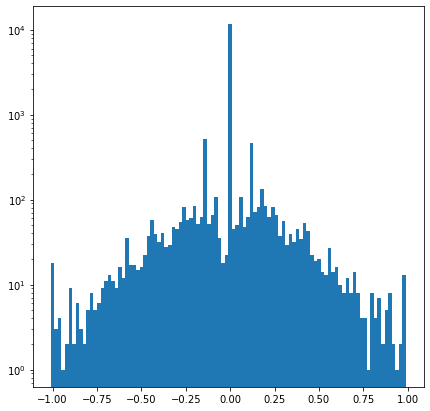

In [14]:
w = model.layers[2].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))



print_qstats(model)

### hls4ml Configuration

/home/selwyn96/enter/envs/venv/lib/python3.8/site-packages/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


Interpreting Model
Topology:
Layer name: layer0, layer type: Input
Layer name: q_relu, layer type: QActivation
Layer name: q_dense, layer type: QDense
Layer name: q_relu_1, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: softmax, layer type: Activation
-----------------------------------
OutputDir:           /crucial/1/selwyn96/ALVEO-PYNQ_ML/training/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj
ProjectName:         myproject
Backend:             VivadoAccelerator
Part:                xcu250-figd2104-2L-e
ClockPeriod:         2
IOType:              io_parallel
HLSConfig
  Model
    ReuseFactor:     36
    Strategy:        Resource
    Precision:       ap_fixed<16,6>
  LayerName
    layer0
      Precision:     ap_ufixed<8,3>
    q_relu
      Precision
        result:      ap_ufixed<2,0>
      ReuseFactor:   1
    q_dense
      Precision
        weight:      ap_fixed<4,1>
        bias:        ap_fixed<5,1>
        result:      ap_fixed<9,4>
   

2022-05-17 18:35:54.109543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-17 18:35:54.110096: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199935000 Hz


   q_dense
   q_relu_1
   q_dense_1
   softmax
Profiling activations (final / after optimization)
Recompiling myproject with tracing
Writing HLS project
Done
Writing HLS project
Done
   q_dense
   q_dense_1
   softmax


(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

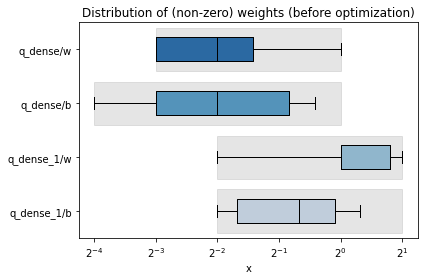

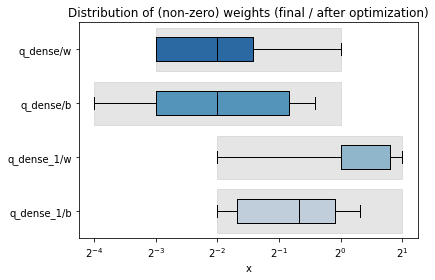

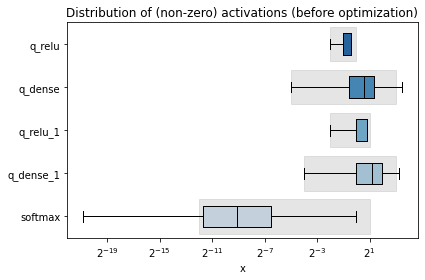

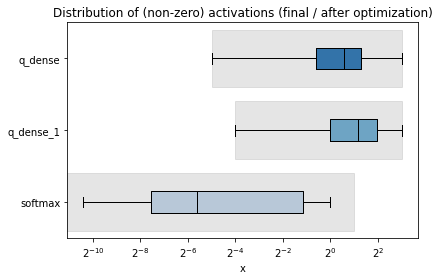

In [15]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'], rounding_mode='AP_RND', saturation_mode='AP_SAT')

Trace = True

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model'] = {}
config['Model']['ReuseFactor'] = 36
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'

config['LayerName']['layer0']['Precision'] = 'ap_ufixed<8,3>'

config['LayerName']['q_dense']['ReuseFactor'] = 28
#config['LayerName']['q_dense']['Precision']['weight']   = 'ap_fixed<2,1>'
#config['LayerName']['q_dense']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense']['Precision']['result']   = 'ap_fixed<9,4>'
config['LayerName']['q_dense']['Trace']       = Trace
#config['LayerName']['q_dense']['Strategy'] = 'Latency'

config['LayerName']['q_dense_1']['ReuseFactor'] = 20
#config['LayerName']['q_dense_1']['Precision']['weight']   = 'ap_fixed<3,1>'
#config['LayerName']['q_dense_1']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense_1']['Precision']['result']   = 'ap_fixed<8,4>'
config['LayerName']['q_dense_1']['Trace']       = Trace
#config['LayerName']['q_dense_1']['Strategy'] = 'Latency'

config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<12,4>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<12,2>'
config['LayerName']['softmax']['table_size']  = 1024
config['LayerName']['softmax']['Precision']   = 'ap_fixed<14,2>'
config['LayerName']['softmax']['Strategy']    = 'Stable'
config['LayerName']['softmax']['Trace']       = Trace


cfg = hls4ml.converters.create_config(board='alveo-u250', clock_period= 2, part='xcu250-figd2104-2L-e', backend='VivadoAccelerator')
cfg['HLSConfig'] = config

cfg['AcceleratorConfig']['Driver']    = 'python'
cfg['AcceleratorConfig']['Board']     = 'alveo-u250'
cfg['AcceleratorConfig']['Interface'] = 'axi_stream'
#cfg['AcceleratorConfig']['Interface'] = 'axi_lite'
#cfg['AcceleratorConfig']['Interface'] = 'axi_master'
cfg['AcceleratorConfig']['Precision']['Input']  = 'float'
cfg['AcceleratorConfig']['Precision']['Output'] = 'float'

cfg['IOType']= 'io_parallel'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Qkeras_pruned_Dense/hls4ml_PYNQ_prj'


print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)
#hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])
hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])



In [16]:
hls_model.compile()

Writing HLS project
Done
Writing HLS project
Done


### Test on CPU

In [17]:
with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))

y_hls = hls_model.predict(np.ascontiguousarray(x_test))

In [18]:
np.save(MODEL_PATH + 'Qkeras_pruned_Dense/HLS_data/y_hls.npy', y_hls)
np.save(DATA_PATH + 'y_hls_Dense.npy', y_hls)

Accuracy pruned, quantized: 0.9272
Accuracy hls4ml: 0.9131


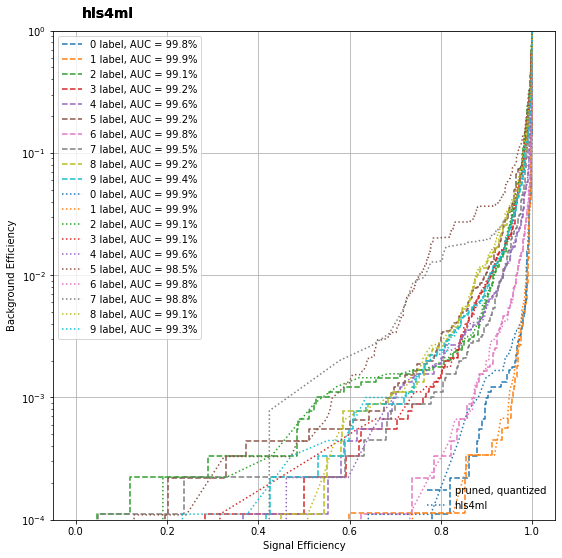

In [19]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

In [20]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [21]:
hls_model.build(csim=False,synth=True,export=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'selwyn96' on host 'prp-gpu-1.t2.ucsd.edu' (Linux_x86_64 version 3.10.0-1160.45.1.el7.x86_64) on Tue May 17 18:36:40 PDT 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/crucial/1/selwyn96/ALVEO-PYNQ_ML/training/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/crucial/1/selwyn96/ALVEO-PYNQ_ML/training/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ

INFO: [SYNCHK 200-10] 0 error(s), 1 warning(s).
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:01:03 ; elapsed = 00:01:05 . Memory (MB): peak = 1656.934 ; gain = 1231.883 ; free physical = 30522 ; free virtual = 111982
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<14, 2, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config8>' (firmware/nnet_utils/nnet_activation.h:268:45).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::linear<ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, linear_config7>' (firmware/nnet_utils/nnet_activation.h:51:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:64) in function 'nnet::dense_resource<ap_ufixed<3, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' for

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 9 process function(s): 
	 'myproject.entry209'
	 'myproject_Block__proc'
	 'nnet::relu<ap_ufixed<8, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<2, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config2>'
	 'nnet::dense_resource<ap_ufixed<2, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config3>'
	 'nnet::linear<ap_fixed<9, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, linear_config4>'
	 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_ufixed<3, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>'
	 'nnet::dense_resource<ap_ufixed<3, 1, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'
	 'nnet::linear<ap_fixed<8, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, linear_config7>'
	 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixe

INFO: [SCHED 204-61] Pipelining function 'relu<ap_ufixed,ap_ufixed<2,0,0,0,0>,relu_config2>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 16.75 seconds; current allocated memory: 840.049 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 65.69 seconds; current allocated memory: 915.830 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_ap_ufixed_ap_fixed_9_4_5_3_0_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelin

INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_ufixed_ap_ufixed_2_0_0_0_0_relu_config2_s'.
INFO: [HLS 200-111]  Elapsed time: 57 seconds; current allocated memory: 2.414 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_ap_ufixed_ap_fixed_9_4_5_3_0_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_325_2_1_1': 560 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_ap_ufixed_ap_fixed_9_4_5_3_0_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 109.24 seconds; current allocated memory: 2.796 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_ap_fixed_ap_fixed_16_6_0_0_0_linear_config4_s' 
INFO: [HLS 200-10] ---------------------------------------

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_23_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_24_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_25_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_26_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_27_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_28_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_29_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_30_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_31_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_32_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO '

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_115_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_116_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_117_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_118_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_119_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_120_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_121_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_122_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_123_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_124_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_202_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_203_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_204_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_205_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_206_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_207_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_208_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_209_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_210_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_211_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_288_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_289_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_290_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_291_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_292_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_293_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_294_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_295_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_296_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_297_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_377_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_378_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_379_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_380_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_381_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_382_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_383_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_384_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_385_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_386_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_462_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_463_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_464_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_465_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_466_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_467_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_468_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_469_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_470_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_471_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_550_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_551_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_552_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_553_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_554_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_555_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_556_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_557_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_558_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_559_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_638_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_639_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_640_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_641_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_642_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_643_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_644_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_645_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_646_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_647_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_726_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_727_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_728_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_729_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_730_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_731_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_732_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_733_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_734_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_735_V_U(fifo_w2_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_9_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_10_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_11_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_12_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_13_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_14_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_15_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_16_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_17_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_18_V_U(fifo_w14_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementi

{'CSynthesisReport': {'EstimatedClockPeriod': '1.739',
  'BestLatency': '880',
  'WorstLatency': '882',
  'IntervalMin': '881',
  'IntervalMax': '883',
  'BRAM_18K': '418',
  'DSP48E': '10',
  'FF': '51332',
  'LUT': '188436',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP48E': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [20]:
hls4ml.report.read_vivado_report(PROJECT_PATH + 'Qkeras_pruned_Dense/hls4ml_PYNQ_prj')

Found 1 solution(s) in /crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Thu May 12 01:15:55 2022

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 2.00 ns | 1.739 ns |   0.25 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   ma

In [19]:
#hls4ml.templates.VivadoAcceleratorBackend.make_bitfile(hls_model)
source /opt/xilinx/xrt/setup.sh
hls4ml.backends.VivadoAcceleratorBackend.make_xclbin(hls_model, 'xilinx_u250_xdma_201830_2')


****** Vivado v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source design.tcl
# set tcldir [file dirname [info script]]
# source [file join $tcldir project.tcl]
## variable myproject
## set myproject "myproject"
## set bit_width_hls_output 32
## set bit_width_hls_input 32
# create_project project_1 ${myproject}_vivado_accelerator -part xcu250-figd2104-2L-e -force
# set_property  ip_repo_paths  ${myproject}_prj [current_project]
# update_ip_catalog
INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1700] Loaded user IP repository '/crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/myproject_prj'.
INFO: [IP_Flow 19-2313] Loaded Vivado IP repository '/xilinx/Vivado/2020.1/data/ip'.
update_ip_catalog: Time (s): cpu = 00:00:02 ; elapsed = 00:00:07 . Memory (MB): peak = 2135.223 ;

INFO: [IP_Flow 19-2181] Payment Required is not set for this core.
INFO: [IP_Flow 19-2187] The Product Guide file is missing.
INFO: [Ipptcl 7-1486] check_integrity: Integrity check passed.
INFO: [Common 17-206] Exiting Vivado at Thu May 12 16:08:45 2022...
Option Map File Used: '/xilinx/Vitis/2020.1/data/vitis/vpp/optMap.xml'

****** v++ v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

INFO: [v++ 60-1306] Additional information associated with this v++ link can be found at:
	Reports: /crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/xclbin_files/_x/reports/link
	Log files: /crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/xclbin_files/_x/logs/link
INFO: [v++ 60-1657] Initializing dispatch client.
Running Dispatch Server on port:43290
INFO: [v++ 60-1548] Creating build summary session with primary 

INFO: [v++ 60-1441] [16:09:28] Run run_link: Step cf2sw: Completed
Time (s): cpu = 00:00:02 ; elapsed = 00:00:02 . Memory (MB): peak = 1335.512 ; gain = 0.000 ; free physical = 39096 ; free virtual = 118673
INFO: [v++ 60-1443] [16:09:28] Run run_link: Step rtd2_system_diagram: Started
INFO: [v++ 60-1453] Command Line: rtd2SystemDiagram
INFO: [v++ 60-1454] Run Directory: /crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/xclbin_files/_x/link/run_link
INFO: [v++ 60-1441] [16:09:30] Run run_link: Step rtd2_system_diagram: Completed
Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:02 . Memory (MB): peak = 1335.512 ; gain = 0.000 ; free physical = 38655 ; free virtual = 118231
INFO: [v++ 60-1443] [16:09:30] Run run_link: Step vpl: Started
INFO: [v++ 60-1453] Command Line: vpl -t hw -f xilinx_u250_xdma_201830_2 --remote_ip_cache /crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/xclbin_files/

[17:03:37] Finished 3rd of 6 tasks (FPGA logic optimization). Elapsed time: 00h 11m 07s 

[17:03:37] Starting logic placement..
[17:04:07] Phase 1 Placer Initialization
[17:04:07] Phase 1.1 Placer Initialization Netlist Sorting
[17:08:10] Phase 1.2 IO Placement/ Clock Placement/ Build Placer Device
[17:09:41] Phase 1.3 Build Placer Netlist Model
[17:12:13] Phase 1.4 Constrain Clocks/Macros
[17:12:43] Phase 2 Global Placement
[17:12:43] Phase 2.1 Floorplanning
[17:13:13] Phase 2.1.1 Partition Driven Placement
[17:13:13] Phase 2.1.1.1 PBP: Partition Driven Placement
[17:14:45] Phase 2.1.1.2 PBP: Clock Region Placement
[17:15:45] Phase 2.1.1.3 PBP: Compute Congestion
[17:15:45] Phase 2.1.1.4 PBP: UpdateTiming
[17:16:16] Phase 2.1.1.5 PBP: Add part constraints
[17:16:46] Phase 2.2 Global Placement Core
[17:27:25] Phase 2.2.1 Physical Synthesis In Placer
[17:30:58] Phase 3 Detail Placement
[17:30:58] Phase 3.1 Commit Multi Column Macros
[17:30:58] Phase 3.2 Commit Most Macros & LUTRAMs
[17:

XRT Build Version: 2.12.427 (2021.2)
       Build Date: 2021-10-09 05:06:49
          Hash ID: 2719b6027e185000fc49783171631db03fc0ef79
Creating a default 'in-memory' xclbin image.

Section: 'DEBUG_IP_LAYOUT'(9) was successfully added.
Size   : 296 bytes
Format : JSON
File   : '/crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/xclbin_files/_x/link/int/debug_ip_layout.rtd'

Section: 'BITSTREAM'(0) was successfully added.
Size   : 60056411 bytes
Format : RAW
File   : '/crucial/1/selwyn96/ALVEO-PYNQ_ML/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/xclbin_files/_x/link/int/partial.bit'

Section: 'MEM_TOPOLOGY'(6) was successfully added.
Format : JSON
File   : 'mem_topology'

Section: 'IP_LAYOUT'(8) was successfully added.
Format : JSON
File   : 'ip_layout'

Section: 'CONNECTIVITY'(7) was successfully added.
Format : JSON
File   : 'connectivity'

Section: 'CLOCK_FREQ_TOPOLOGY'(11) was successfully added.
Size   : 27

In [ ]:
with tf.device('/cpu:0'):
    %timeit y_qkeras = model.predict((x_test))

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from utils import plotting

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
    
y_hls = np.load(DATA_PATH + 'y_hls_Dense.npy')

y_FPGA = np.load(DATA_PATH + 'y_alveo_Dense.npy') 

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("Accuracy FPGA: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_FPGA, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]                )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':' )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_FPGA  , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='-.')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls=':'),
         Line2D([0], [0], ls='-.')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['qkeras_pruned', 'hls4ml', 'FPGA inf'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

fig.facecolor='yellow'

fig.savefig(PLOTS_PATH + '/Final_AUC_plot', bbox_inches='tight')

### BIG Dense

In [ ]:
(x_train, y_train), (x_test, y_test) = get_train_test_set(nn_type='Dense')

In [ ]:
model = get_bigdense_qmodel()

model.summary()

In [ ]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras             import strip_pruning

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=5000, frequency=4000)}
model = prune.prune_low_magnitude(model, **pruning_params)

In [ ]:
train = False
if train:
    
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor     = 0.5,
                              lr_patience   = 20,
                              lr_epsilon    = 0.00001,
                              lr_cooldown   = 5,
                              lr_minimum    = 0.00001,
                              verbose       = False,
                              outputDir = MODEL_PATH + 'Qkeras_pruned_bigdense')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    with tf.device('/cpu:0'):
        model.fit(x_train, y_train, batch_size=128,
                  epochs=80, validation_split=0.25, shuffle=True,
                  verbose = 1,
                  callbacks = callbacks.callbacks)
    with tf.device('/cpu:0'):
    # Save the model again but with the pruning 'stripped' to use the regular layer types
        model = strip_pruning(model)
        model.save( MODEL_PATH + 'Qkeras_pruned_bigdense/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model( MODEL_PATH + 'Qkeras_pruned_bigdense/KERAS_check_best_model.h5', custom_objects=co)
    model.compile()
    model.summary()

In [ ]:
print_qstats(model)

In [ ]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'


Trace = True

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model'] = {}
config['Model']['ReuseFactor'] = 36
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'

config['LayerName']['layer0']['Precision'] = 'ap_ufixed<8,3>'

config['LayerName']['q_dense']['ReuseFactor'] = 28
#config['LayerName']['q_dense']['Precision']['weight']   = 'ap_fixed<2,1>'
#config['LayerName']['q_dense']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense']['Precision']['result']   = 'ap_fixed<9,4>'
config['LayerName']['q_dense']['Trace']       = Trace
#config['LayerName']['q_dense']['Strategy'] = 'Latency'

config['LayerName']['q_dense_1']['ReuseFactor'] = 20
#config['LayerName']['q_dense_1']['Precision']['weight']   = 'ap_fixed<3,1>'
#config['LayerName']['q_dense_1']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense_1']['Precision']['result']   = 'ap_fixed<8,4>'
config['LayerName']['q_dense_1']['Trace']       = Trace
#config['LayerName']['q_dense_1']['Strategy'] = 'Latency'

config['LayerName']['q_dense_2']['ReuseFactor'] = 20
#config['LayerName']['q_dense_2']['Precision']['weight']   = 'ap_fixed<2,1>'
#config['LayerName']['q_dense_2']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense_2']['Precision']['result']   = 'ap_fixed<9,5>'
config['LayerName']['q_dense_2']['Trace']       = Trace
#config['LayerName']['q_dense_2']['Strategy'] = 'Latency'

config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<12,4>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<12,2>'
config['LayerName']['softmax']['table_size']  = 1024
config['LayerName']['softmax']['Precision']   = 'ap_fixed<14,2>'
config['LayerName']['softmax']['Strategy']    = 'Stable'
config['LayerName']['softmax']['Trace']       = Trace


cfg = hls4ml.converters.create_config(board='alveo-u250', clock_period= 2, part='xcu250-figd2104-2L-e', backend='VivadoAccelerator')
cfg['HLSConfig'] = config

cfg['AcceleratorConfig']['Driver']    = 'python'
cfg['AcceleratorConfig']['Board']     = 'alveo-u250'
cfg['AcceleratorConfig']['Interface'] = 'axi_stream'
#cfg['AcceleratorConfig']['Interface'] = 'axi_lite'
#cfg['AcceleratorConfig']['Interface'] = 'axi_master'
cfg['AcceleratorConfig']['Precision']['Input']  = 'float'
cfg['AcceleratorConfig']['Precision']['Output'] = 'float'

cfg['IOType']= 'io_parallel'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Qkeras_pruned_bigdense/hls4ml_PYNQ_prj'


print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])  

In [ ]:
hls_model.compile()

In [ ]:
with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
y_hls = hls_model.predict(np.ascontiguousarray(x_test))

In [ ]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

In [ ]:
hls_model.build(csim=False,synth=True,export=True)

In [ ]:
hls4ml.report.read_vivado_report(PROJECT_PATH + 'Qkeras_pruned_Dense/hls4ml_PYNQ_prj')

In [ ]:
#!source /opt/xilinx/xrt/setup.sh
hls4ml.templates.VivadoAcceleratorBackend.make_xclbin(hls_model, 'xilinx_u250_xdma_201830_2')